# Visualization of Features and Exploratory Analysis
Here we look at the extracted fetures and do some exploratory analysis.

In [1]:
#load libraries
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.discriminant_analysis
import sklearn.manifold 
import librosa
import librosa.display
import numpy
import random
import pandas
import seaborn
import json

### Load Features
After the extraction of the features using the code provided in **Feature_Extraction.ipynb** we can simply load them from the .txt files (this will save time since feature extration can take a while).

In [2]:
with open('x_unnorm.txt', 'r') as filehandle:
    y = json.load(filehandle)

In [3]:
with open('SR.txt', 'r') as filehandle:
    SR = json.load(filehandle)
with open('MFCC.txt', 'r') as filehandle:
    MFCC = json.load(filehandle)

In [4]:
##convert mfccs from list to numpy array that are faster to work with
x={}
for sr in SR:
    x[sr]={}
    for n_mfcc in MFCC:
        x[sr][n_mfcc]=[]
            
for sr in y:
    for n_mfcc in y[sr]:
        for t in y[sr][n_mfcc]:
            x[int(sr)][int(n_mfcc)].append({"artist": t["artist"],
                                            "song": t["song"],
                                            "mfcc":numpy.asarray(t["mfcc"])})

### Different ways of visualizing a song:
To visualize a single song there are lots of different ways:

1) waveplot = plot of the wave the represent the sound

2) spectrogram = how the spectrum(=fast fourier trasform of the wave) varies over time 

3) chormagram = how the energy varies in each of the 12 pitch classes

4) mfcc = mel frequency cepstral coefficient, hardly intepretable but usefull for classification

In [2]:
path="Dataset\\Ed Sheeran\\+ (Deluxe Version)\\01 The a Team.mp3"
a = librosa.load(path,duration=60,offset=5,sr=22050)[0]

c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\librosa\core\audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


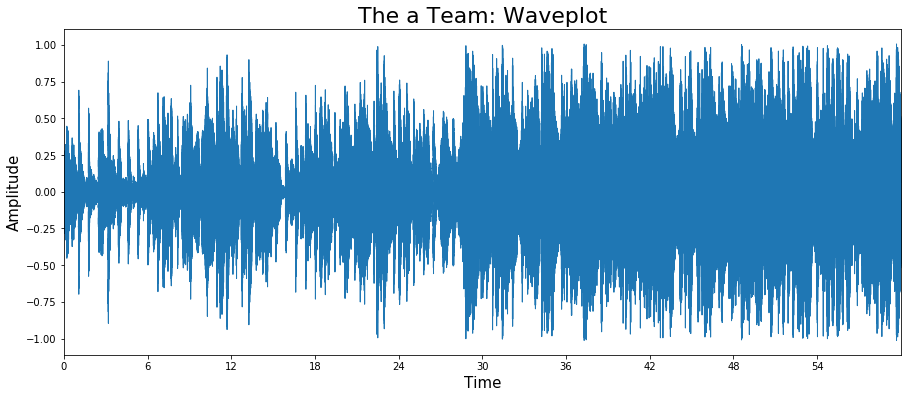

In [3]:
#waveplot
plt.figure(figsize=(15, 6))
librosa.display.waveplot(a)
plt.ylabel('Amplitude',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.title("The a Team: Waveplot", fontsize=22)
#plt.show()
plt.savefig('w.svg')

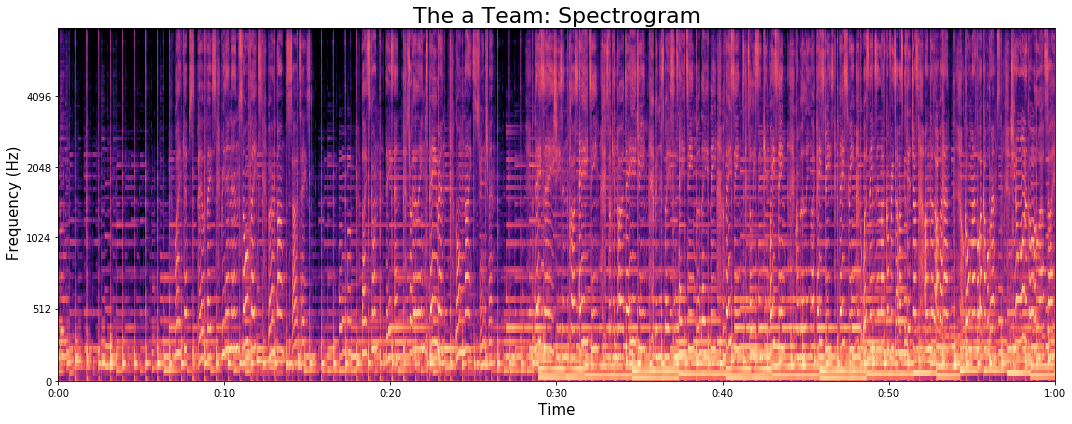

In [4]:
#spectrogram (in Mel scale)
plt.figure(figsize=(15, 6))
S=librosa.feature.melspectrogram(y=a, sr=22050)
S_dB = librosa.power_to_db(S, ref=numpy.max)
librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=22050,fmax=8000)
#plt.colorbar(format='%+2.0f dB')
plt.ylabel(' Frequency (Hz)',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.title("The a Team: Spectrogram", fontsize=22)
plt.tight_layout()
#plt.show()
plt.savefig('s.svg')

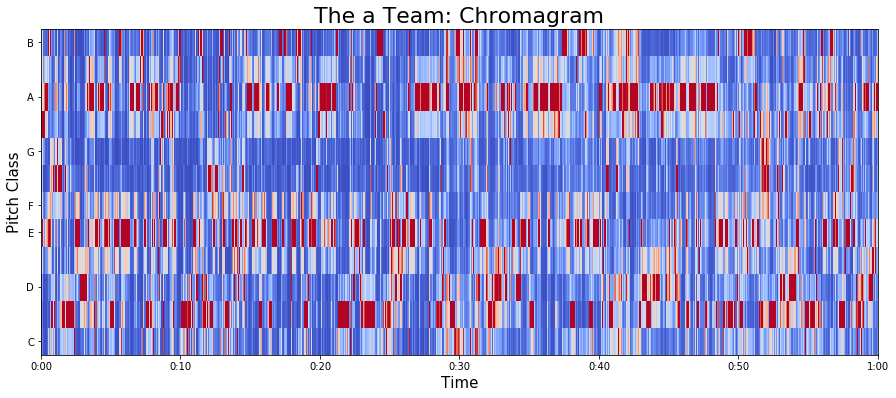

In [5]:
#chromagram
plt.figure(figsize=(15, 6))
chromagram = librosa.feature.chroma_stft(a, sr=22050, hop_length=512)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Pitch Class',fontsize=15)
plt.title("The a Team: Chromagram",fontsize=22)
#plt.show()
plt.savefig('c.svg')

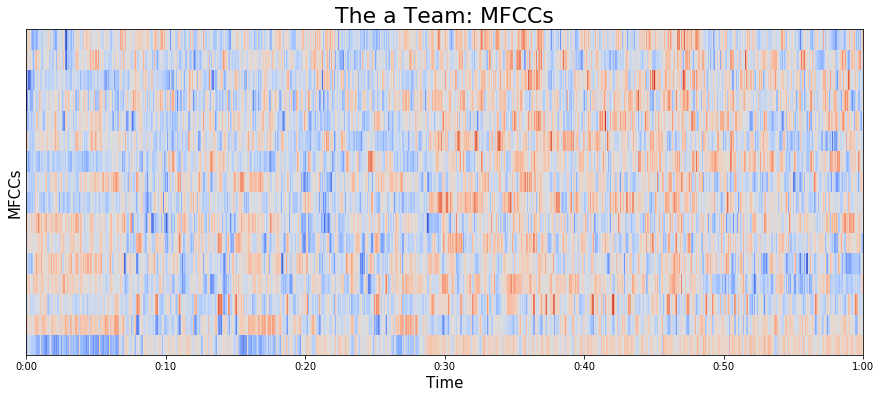

In [6]:
mfcc = librosa.feature.mfcc(a, sr=22050,n_mfcc=16)
scaler = sklearn.preprocessing.StandardScaler()
mfcc = scaler.fit_transform(mfcc.T)
plt.figure(figsize=(15, 6))
librosa.display.specshow(mfcc.T, sr=22050, x_axis='time')
plt.xlabel('Time',fontsize=15)
plt.ylabel("MFCCs", fontsize=15)
plt.title("The a Team: MFCCs",fontsize=22)
#plt.show()
plt.savefig('m.svg')

### Prepare data for PCA visualization

In [5]:
##create a list of artist in the dataset
artistlist=[]
for t in x[2500][4]:
    if t["artist"] not in artistlist:
        artistlist.append(t["artist"])
artistlist.sort()
#print(artistlist)

In [13]:
##############################################
#####data for PCA visualization at frame level
##############################################
sr=10000
n_mfcc=20


###create a matrix with all frames of all songs
all_mfcc=numpy.empty((1,n_mfcc))
for t in x[sr][n_mfcc]:
    all_mfcc=numpy.vstack((all_mfcc, t["mfcc"]))
all_mfcc=numpy.delete(all_mfcc,0,0)
scaler = sklearn.preprocessing.StandardScaler()
all_mfcc=scaler.fit_transform(all_mfcc)

###create a list of corresponding labels and convert to pandas df
all_labels=[]
for t in x[sr][n_mfcc]:
    for _ in range(t["mfcc"].shape[0]):
        all_labels.append(t["artist"])
all_labels=pandas.DataFrame(all_labels, columns = ["artist"])
#all_labels

#create data frame with first two pc and artist label for the mfccs of all frames
PCA = sklearn.decomposition.PCA(n_components=2)
mfcc_principalComponents = PCA.fit_transform(all_mfcc)
mfcc_principalComponents = pandas.DataFrame(data = mfcc_principalComponents, columns = ['pc1', 'pc2'])
df_frames = pandas.concat([mfcc_principalComponents, all_labels],axis=1)
#df_frames

In [18]:
##############################################
######data for PCA visualization at song level
##############################################
sr=10000
n_mfcc=20

#for each song take the average of their mfccs along all its frames
song_mfcc=numpy.empty((1,n_mfcc))
for t in x[sr][n_mfcc]:
    song_mfcc=numpy.vstack((song_mfcc, t["mfcc"].sum(axis=0)))
song_mfcc=numpy.delete(song_mfcc,0,0)
scaler = sklearn.preprocessing.StandardScaler()
song_mfcc=scaler.fit_transform(song_mfcc)


#create a label with artist for the above averages
song_labels=[]
for t in x[sr][n_mfcc]:
    song_labels.append(t["artist"])
song_labels=pandas.DataFrame(song_labels, columns = ["artist"])

#create data frame with first two pc and artist label for the mfccs of all frames
PCA = sklearn.decomposition.PCA(n_components=2)
mfcc_avg_principalComponents = PCA.fit_transform(song_mfcc)
mfcc_avg_principalComponents = pandas.DataFrame(data = mfcc_avg_principalComponents, columns = ['pc1', 'pc2'])
df_song = pandas.concat([mfcc_avg_principalComponents, song_labels],axis=1)
#df_song

### PCA visualization both at frame and song level

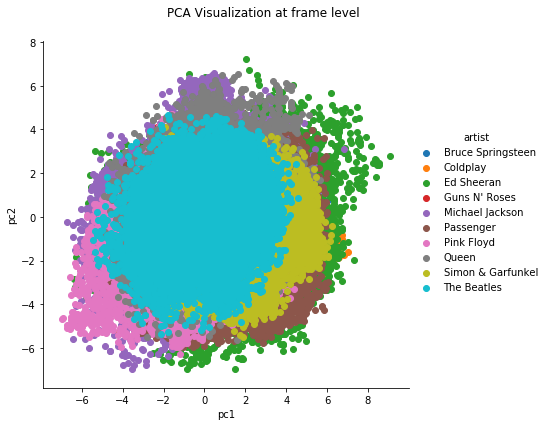

In [16]:
###RUN code to get data for this visualization before visualizing
###because the differt kind of visualization may have conflicting names


#manual way
"""fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA of Frames', fontsize = 20)

targets = artistlist
colors = ['r','g','b','c','m','y','k']
for target, color in zip(targets,colors):
    indicesToKeep = df_frames['artist'] == target
    ax.scatter(df_frames.loc[indicesToKeep, 'pc1']
               , df_frames.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50
               , alpha=0.5)
ax.legend(targets)
ax.grid()"""



#alternative one line code
#filter to show only desidered artists. to show all use artistlist in place of printlist
#printlist=['Queen','Simon & Garfunkel']
printlist=artistlist
p=seaborn.FacetGrid(df_frames[df_frames.artist.isin(printlist)],hue="artist", size=6)
p.map(plt.scatter, "pc1", "pc2")
p.add_legend()
plt.subplots_adjust(top=0.9)
p.fig.suptitle('PCA Visualization at frame level') 
plt.show()

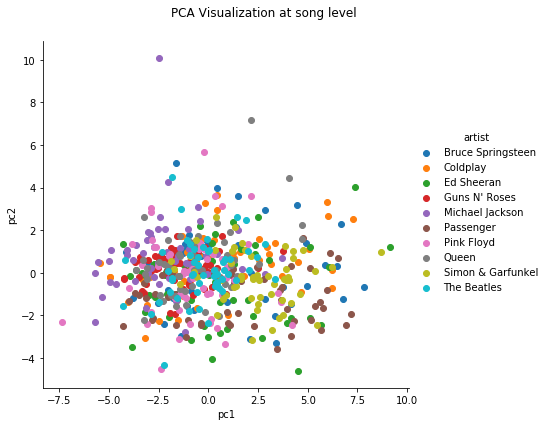

In [19]:
###RUN code to get data for this visualization before visualizing
###because the differt kind of visualization may have conflicting names

"""fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA of songs', fontsize = 20)

targets = artistlist
colors = ['r','g','b','c','m','y','k']
for target, color in zip(targets,colors):
    indicesToKeep = df_song['artist'] == target
    ax.scatter(df_song.loc[indicesToKeep, 'pc1']
               , df_song.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50
               , alpha=0.8)
ax.legend(targets)
ax.grid()
"""

#alternative
#filter to show only desidered artists. to show all use artistlist in place of printlist
printlist=['Queen','Simon & Garfunkel']
printlist=artistlist
p=seaborn.FacetGrid(df_song[df_song.artist.isin(printlist)],hue="artist", height=6)
p.map(plt.scatter, "pc1", "pc2")
p.add_legend()
plt.subplots_adjust(top=0.9)
p.fig.suptitle('PCA Visualization at song level') 
plt.show()

### Scatterplot matrix of all mfcc of  all artists

In [42]:
sr=2500
n_mfcc=8


###create a matrix with all frames of all songs
all_mfcc=numpy.empty((1,n_mfcc))
for t in x[sr][n_mfcc]:
    all_mfcc=numpy.vstack((all_mfcc, t["mfcc"]))
all_mfcc=numpy.delete(all_mfcc,0,0)
scaler = sklearn.preprocessing.StandardScaler()
all_mfcc=scaler.fit_transform(all_mfcc)
all_mfcc=pandas.DataFrame(all_mfcc)

###create a list of corresponding labels and convert to pandas df
all_labels=[]
for t in x[sr][n_mfcc]:
    for _ in range(t["mfcc"].shape[0]):
        all_labels.append(t["artist"])
all_labels=pandas.DataFrame(all_labels, columns = ["artist"])


#concatenate horizontally the two pandas dataframes
df = pandas.concat([all_mfcc, all_labels], axis=1)

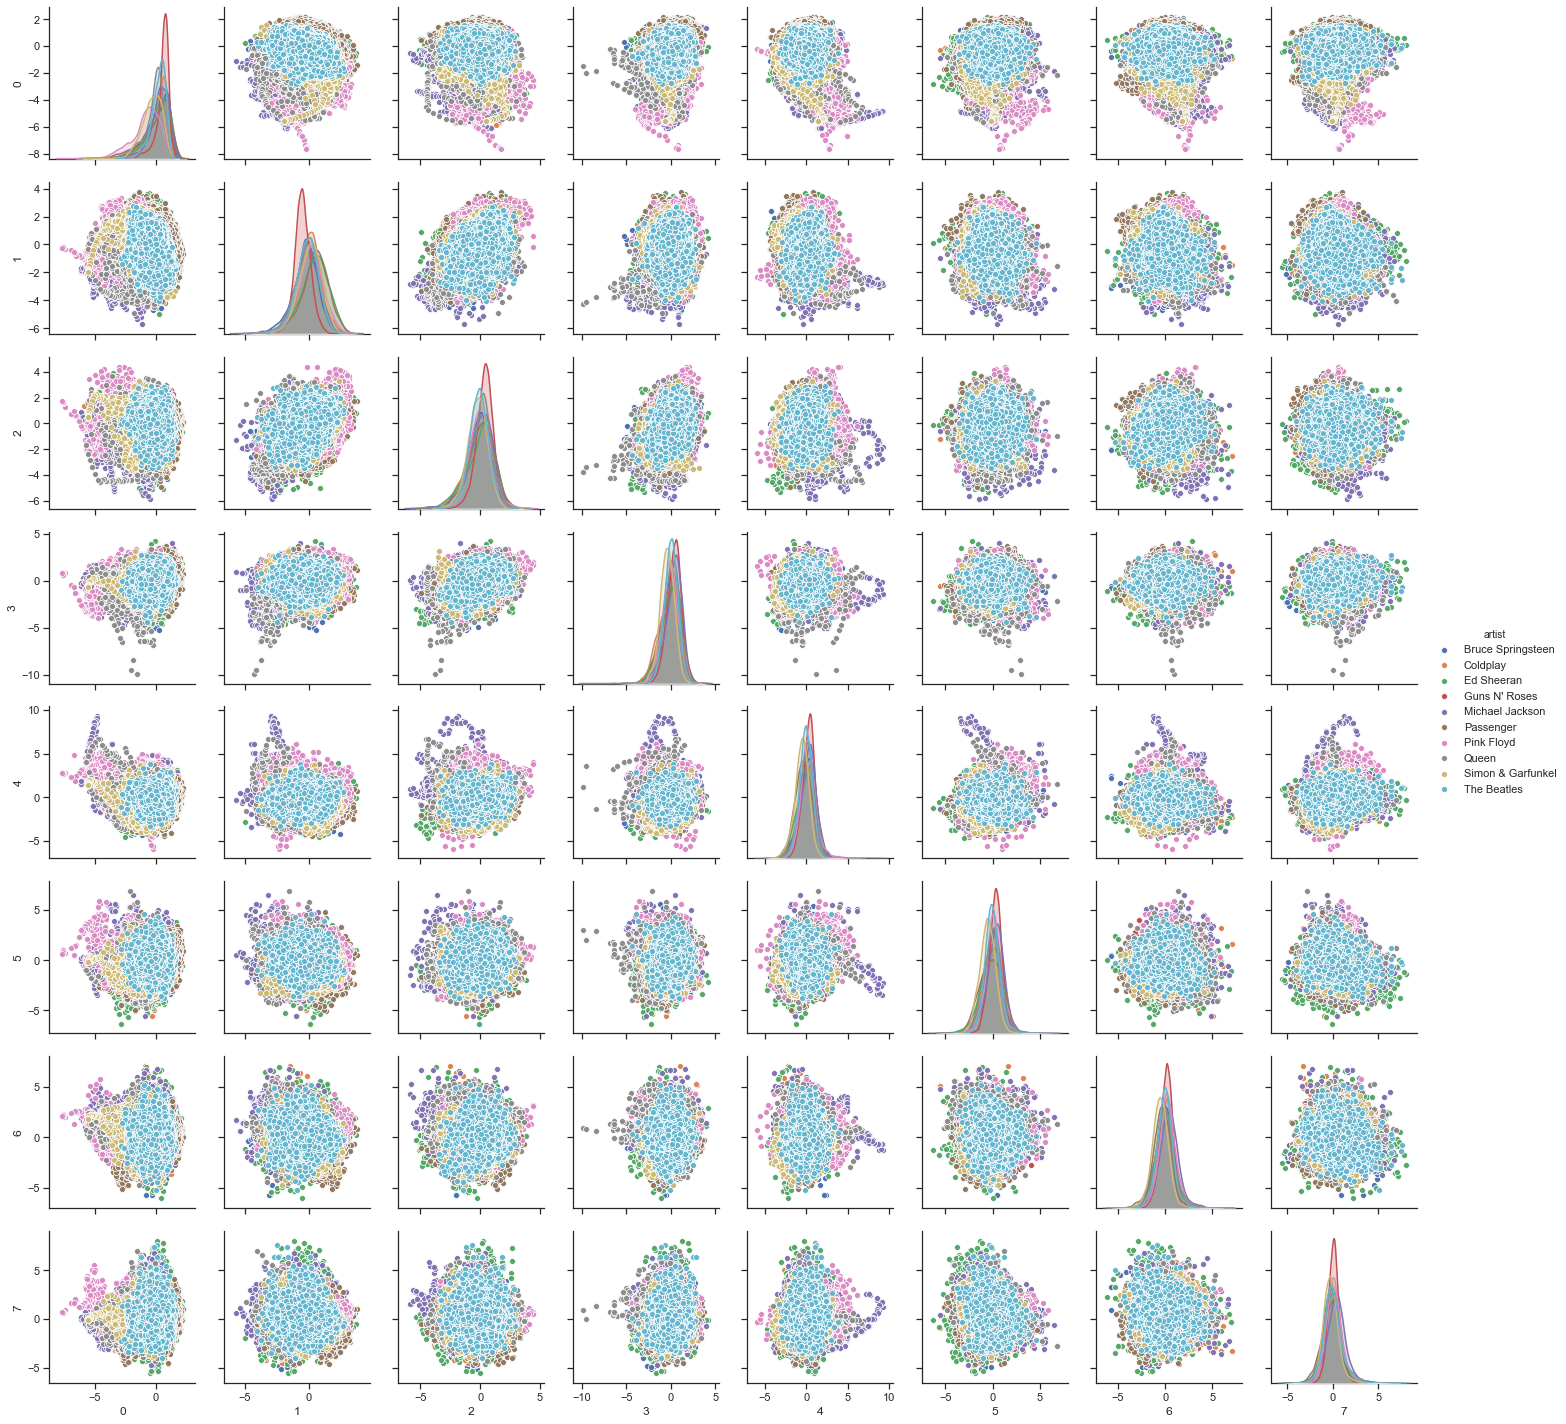

In [43]:
#####plot
seaborn.set(style="ticks")
seaborn.pairplot(df, hue="artist")

### Correlation Matrix

In [10]:
sr=10000
n_mfcc=20

###create a df with all frames of all songs
all_mfcc=numpy.empty((1,n_mfcc))
for t in x[sr][n_mfcc]:
    all_mfcc=numpy.vstack((all_mfcc, t["mfcc"]))
all_mfcc=numpy.delete(all_mfcc,0,0)
#scaler = sklearn.preprocessing.StandardScaler()
#all_mfcc=scaler.fit_transform(all_mfcc)
all_mfcc=pandas.DataFrame(all_mfcc)

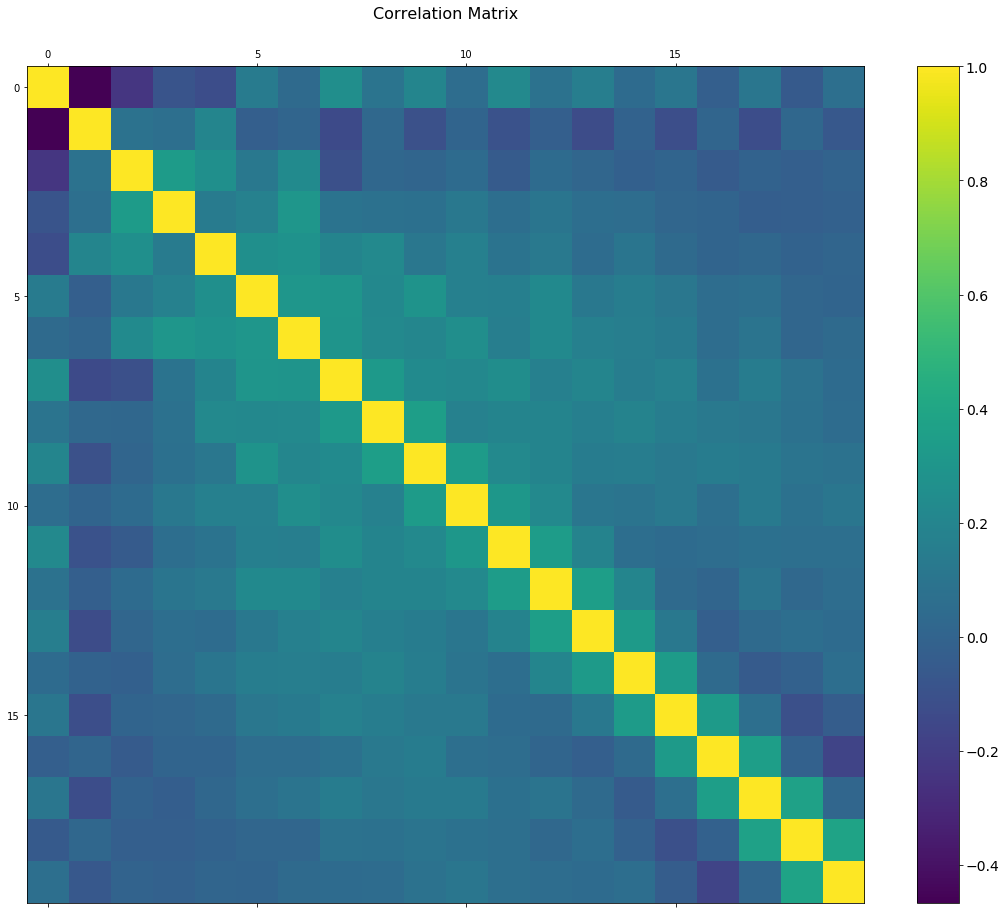

In [11]:
f = plt.figure(figsize=(19, 15))
plt.matshow(all_mfcc.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.savefig('corr.svg')

# Visualization of the Heatmaps of results combined
### Load Data

In [2]:
SR=[2500,5000,7500,10000]
MFCC=[4,8,12,16,20]
artistlist=['Bruce Springsteen','Coldplay','Ed Sheeran', "Guns N' Roses"
            , 'Michael Jackson', 'Passenger', 'Pink Floyd', 'Queen', 'Simon & Garfunkel' , 'The Beatles']

In [3]:
#load confusion matrix of knn
with open('CM_knn.txt', 'r') as filehandle:
    CM2 = json.load(filehandle)
CM_knn={}
for sr in SR:
    CM_knn[sr]={}
    for n_mfcc in MFCC:
        CM_knn[sr][n_mfcc]=pandas.DataFrame(numpy.asarray(CM2[str(sr)][str(n_mfcc)])
                                         , columns = artistlist, index=artistlist)

In [4]:
#load confusion matrix of GMM
with open('CM_GMM.txt', 'r') as filehandle:
    CM2 = json.load(filehandle)
CM_GMM={}
for sr in SR:
    CM_GMM[sr]={}
    for n_mfcc in MFCC:
        CM_GMM[sr][n_mfcc]=pandas.DataFrame(numpy.asarray(CM2[str(sr)][str(n_mfcc)])
                                         , columns = artistlist, index=artistlist)

In [5]:
#load confusion matrix of GMM with frame selection
with open('CM_GMM.txt', 'r') as filehandle:
    CM2 = json.load(filehandle)
CM_GMM_fs={}
for sr in SR:
    CM_GMM_fs[sr]={}
    for n_mfcc in MFCC:
        CM_GMM_fs[sr][n_mfcc]=pandas.DataFrame(numpy.asarray(CM2[str(sr)][str(n_mfcc)])
                                         , columns = artistlist, index=artistlist)

### Compute Errors

In [6]:
#inizialize dictionaries for micro measures of performance of knn
F1_knn={}
for sr in SR:
    F1_knn[sr]={}
    for n_mfcc in MFCC:
        F1_knn[sr][n_mfcc]=0

#calculate precison and recall and F1 (Micro-averaged)
for sr in SR:
    for n_mfcc in MFCC:
        cm=numpy.asarray(CM_knn[sr][n_mfcc])
        recall = (numpy.trace(cm) / numpy.sum(numpy.sum(cm, axis = 1)))
        precision = (numpy.trace(cm) / numpy.sum(numpy.sum(cm, axis = 0)))
        F1 = (2*precision*recall)/(precision+recall)
        F1_knn[sr][n_mfcc]=F1

In [7]:
#inizialize dictionaries for micro measures of performance of GMM
F1_GMM={}
for sr in SR:
    F1_GMM[sr]={}
    for n_mfcc in MFCC:
        F1_GMM[sr][n_mfcc]=0

#calculate precison and recall and F1 (Micro-averaged)
for sr in SR:
    for n_mfcc in MFCC:
        cm=numpy.asarray(CM_GMM[sr][n_mfcc])
        recall = (numpy.trace(cm) / numpy.sum(numpy.sum(cm, axis = 1)))
        precision = (numpy.trace(cm) / numpy.sum(numpy.sum(cm, axis = 0)))
        F1 = (2*precision*recall)/(precision+recall)
        F1_GMM[sr][n_mfcc]=F1

In [8]:
#inizialize dictionaries for micro measures of performance of GMM with frame selection
F1_GMM_fs={}
for sr in SR:
    F1_GMM_fs[sr]={}
    for n_mfcc in MFCC:
        F1_GMM_fs[sr][n_mfcc]=0

#calculate precison and recall and F1 (Micro-averaged)
for sr in SR:
    for n_mfcc in MFCC:
        cm=numpy.asarray(CM_GMM_fs[sr][n_mfcc])
        recall = (numpy.trace(cm) / numpy.sum(numpy.sum(cm, axis = 1)))
        precision = (numpy.trace(cm) / numpy.sum(numpy.sum(cm, axis = 0)))
        F1 = (2*precision*recall)/(precision+recall)
        F1_GMM_fs[sr][n_mfcc]=F1

### Plot Heatmaps

In [9]:
knn = pandas.DataFrame(numpy.zeros(shape=(len(SR),len(MFCC))), columns = MFCC, index=SR)
for sr in SR:
    for n_mfcc in MFCC:
        knn[n_mfcc][sr]=F1_knn[sr][n_mfcc]
        
GMM = pandas.DataFrame(numpy.zeros(shape=(len(SR),len(MFCC))), columns = MFCC, index=SR)
for sr in SR:
    for n_mfcc in MFCC:
        GMM[n_mfcc][sr]=F1_GMM[sr][n_mfcc]

c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # Remove the CWD from sys.path while we load stuff.
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


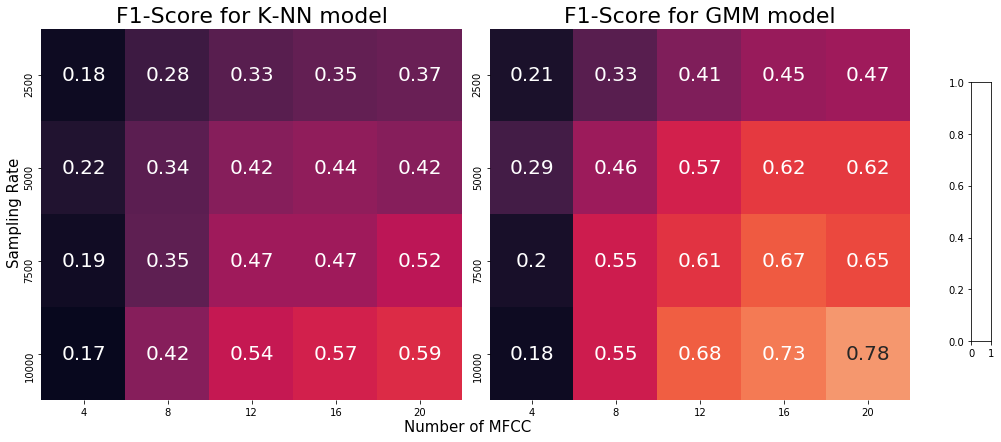

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
cbar_ax = fig.add_axes([.95, .2, .02, .6])
ax1, ax2 = axes
seaborn.heatmap(knn,ax=ax1,vmin=0.15, vmax=0.95,cbar=0, annot=True,annot_kws={"size": 20})
seaborn.heatmap(GMM,ax=ax2,vmin=0.15, vmax=0.95,cbar=0, annot=True,annot_kws={"size": 20})
ax1.set_title('F1-Score for K-NN model',fontsize=22)
ax2.set_title('F1-Score for GMM model',fontsize=22)
fig.text(0.45, 0.001, 'Number of MFCC', ha='center', va='center',fontsize=15)
fig.text(0.001, 0.5, 'Sampling Rate', ha='center', va='center', rotation='vertical',fontsize=15)
fig.tight_layout(rect=[0, 0, .9, 1])
fig.show()
plt.savefig('heat.svg')